# Automated Model Discovery for Rubber

Model Discovery Papers:
1. Invariant-based: https://www.sciencedirect.com/science/article/pii/S1742706123000661
2. Principal-stretch-based: https://www.sciencedirect.com/science/article/pii/S2666522023000047

Rubber Data Reference: https://pubs.rsc.org/en/content/articlelanding/1944/tf/tf9444000059

Code by Denisa Martonová Last edited August 2025




### 0. Load python packages

In [ ]:
# matplotlib 3.7 and above removed key plotting features used in this notebook; tensorflow is starting to move some aspects to legacy in 2.13.0 but it will run still
!pip install matplotlib==3.2.2
!pip install tensorflow==2.12.0

In [ ]:
# import necessary python packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import json
import pandas as pd
import os
import copy
from sklearn.metrics import r2_score


# Check Versions
print('Numpy: ' + np.__version__)
print('Matplotlib: ' + matplotlib.__version__) # must be 3.2.2
print('Tensorflow: ' + tf.__version__)
#print('Keras: ' + keras.__version__) # comment out if using tf 2.13.0

Numpy: 1.23.5
Matplotlib: 3.2.2
Tensorflow: 2.12.0


In [ ]:
#Import excel file, change to match where you saved the file
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/CANN_Stanford/generalized_invariants/' # change to where you download this; must be in Google Drive
dfs = pd.read_excel(path + 'input/CANNsRUBBERdata.xlsx', sheet_name='Sheet1')

Mounted at /content/drive


### 1. Load Rubber data

In [ ]:
# Load data
def getStressStrain(Region):
    if Region =='rubber':
        if Region =='rubber':
            lam1_bi= dfs.iloc[4:18,3].dropna().astype(np.float64).values
            T1_bi = dfs.iloc[4:18,5].dropna().astype(np.float64).values*lam1_bi

            #exclude pure shear for training
            lam1_ps= tf.ones_like(lam1_bi)
            T1_ps = tf.zeros_like(lam1_bi)

            lam_uni = dfs.iloc[4:18,0].dropna().astype(np.float64).values
            T1_uni = dfs.iloc[4:18,2].dropna().astype(np.float64).values*lam_uni
    return lam1_bi,T1_bi,lam1_ps,T1_ps, lam_uni, T1_uni

# Define different loading protocols
def traindata(modelFit_mode):
    if modelFit_mode == 'bi':
        model_given = model_bi
        input_train = [lam1,lam2]
        output_train = [T1_bi,T2_bi]
        sample_weights = np.array([1.0] * lam1.shape[0])


    elif modelFit_mode == "uni":
        model_given = model_uni
        input_train = lam_uni
        output_train = T1_uni
        sample_weights = np.array([1.0]*input_train.shape[0])

    elif modelFit_mode == "combi":
        model_given = model_combi
        input_train = [lam1_bi,lam1_ps,lam_uni]
        output_train = [T1_bi,T1_ps,T1_uni]
        #sample_weights = np.array([1.0] * lam1.shape[0])

    return model_given, input_train, output_train


Region_test = 'rubber'
lam1_bi,T1_bi,lam1_ps,T1_ps, lam_uni, T1_uni = getStressStrain(Region_test)


Text(0.5, 1.0, 'rubber data')

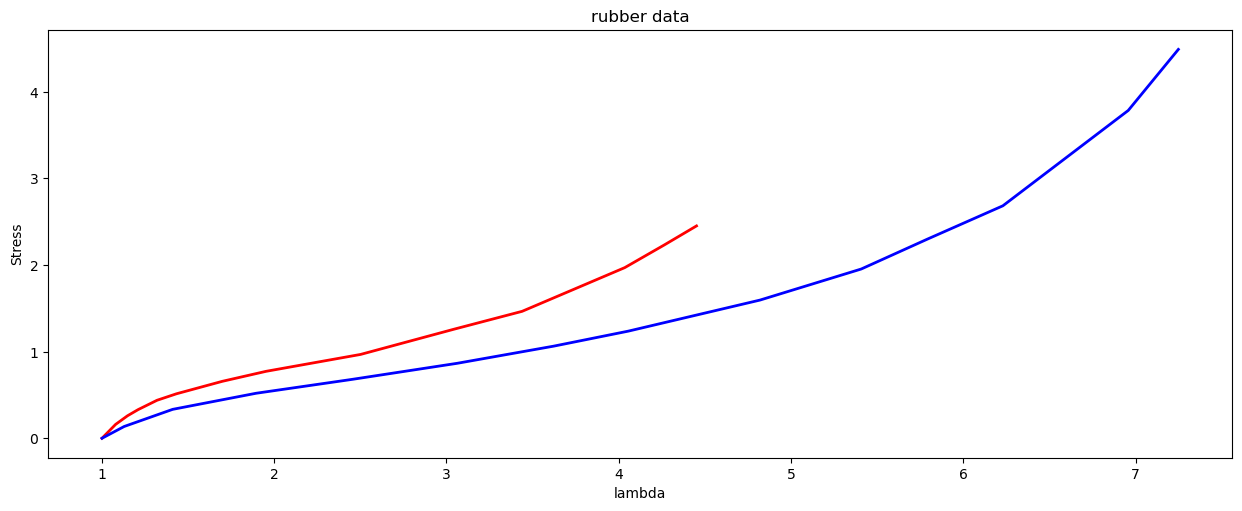

In [ ]:
# plotshear
plt.figure(figsize=(1100/72,400/72))
plt.plot(lam1_bi,T1_bi/lam1_bi, linewidth=2.0,color='red')
plt.plot(lam1_ps,T1_ps/lam1_ps, linewidth=2.0,color='g')
plt.plot(lam_uni,T1_uni/lam_uni, linewidth=2.0,color='blue')
plt.xlabel('lambda')
plt.ylabel('Stress')
plt.title('rubber data')

### L1 and L2 regularization with penalty weight



In [ ]:
def regularize(reg, pen):
    if reg == 'L2':
        return keras.regularizers.l2(pen)
    if reg == 'L1':
        return keras.regularizers.l1(pen)

## 2a. Strain Energy Model - Invariant-based


Next, we define the strain energy function for our isotropic, perfectly incompressible Constitutive Artificial Neural Network with two hidden layers and four and twelve nodes using the invariants of the right Cauchy Green tensor. The first layer generates powers $(\circ)^1$ and $(\circ)^2$ of the network inputs,
$[I_1-3]$ and $[I_2-3]$, and the second layer applies the identity, $(\circ)$, the exponential function, $(\rm{exp}((\circ))-1)$, and the natural logarithm, $(-\rm{ln}(1-(\circ)))$, to these powers.
The set of equations for this networks takes the following explicit form,


$$
\begin{array}{l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{.02cm}}l@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.04cm}}
              l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.0cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}c@{\hspace*{0.1cm}}
              l@{\hspace*{0.1cm}}l@{\hspace*{0.1cm}}l@{\hspace*{0.0cm}}l}
    \psi(I_1,I_2)
&=& w_{2,1}&w_{1,1} &[\,I_1 - 3\,]
&+& w_{2,2} & [ \, \exp (\,     w_{1,2} & [\, I_1 -3 \,]&)   - 1\,]
&-& w_{2,3} &      \ln (\, 1 -  w_{1,3} & [\, I_1 -3 \,]&) \\
&+& w_{2,4}&w_{1,4} &[\,I_1 - 3\,]^2
&+& w_{2,5} & [ \, \exp (\,     w_{1,5} & [\, I_1 -3 \,]^2&) - 1\,]
&-& w_{2,6} &      \ln (\, 1 -  w_{1,6} & [\, I_1 -3 \,]^2&) \\
&+& w_{2,7}&w_{1,7} &[\,I_2 - 3\,]
&+& w_{2,8} & [ \, \exp (\,     w_{1,8} & [\, I_2 -3 \,]&)   - 1\,]
&-& w_{2,9} &      \ln (\, 1 -  w_{1,9} & [\, I_2 -3 \,]&)\\
&+& w_{2,10}&w_{1,10} &[\,I_2 - 3\,]^2
&+& w_{2,11} & [ \, \exp (\,    w_{1,11} & [\, I_2 -3 \,]^2&)- 1\,]
&-& w_{2,12} &      \ln (\, 1 - w_{1,12} & [\, I_2 -3 \,]^2&) \,.
\end{array}
$$


First we define the activation functions and a single Invariant block:

In [ ]:
initializer_exp = tf.keras.initializers.RandomUniform(minval=0., maxval=0.1, seed=np.random.randint(0,10000)) # use random integer as seed
initializer_1 = 'glorot_normal'

# Self defined activation functions for exp term
def activation_Exp(x):
    return 1.0*(tf.math.exp(x) -1.0)
# Self defined activation functions for ln term
def activation_ln(x):
    return -1.0*tf.math.log(1.0 - (x))

# Define network block
## kernel is weight
def SingleInvNet(I1_ref, idi, reg, pen):
    # input: invariant
    I_1_w11 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=None,name='w'+str(1+idi)+'1')(I1_ref) # no activation, correspont to the top ptahway in graph
    I_1_w21 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                                 use_bias=False, activation=activation_Exp,name='w'+str(2+idi)+'1')(I1_ref) # exp activation, 2nd line in graph

    I_1_w31 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
                                 kernel_regularizer=regularize(reg, pen),
                              use_bias=False, activation=activation_ln,name='w'+str(3+idi)+'1')(I1_ref) # ln activation

    # # # input: invariant^2
    # I_1_w41 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
    #                              kernel_regularizer=regularize(reg, pen),
    #                              use_bias=False, activation=None,name='w'+str(4+idi)+'1')(tf.math.square(I1_ref)) # no activation
    # I_1_w51 = keras.layers.Dense(1,kernel_initializer=initializer_exp,kernel_constraint=keras.constraints.NonNeg(),
    #                              kernel_regularizer=regularize(reg, pen),
    #                              use_bias=False, activation=activation_Exp,name='w'+str(5+idi)+'1')(tf.math.square(I1_ref)) # exp activation
    # I_1_w61 = keras.layers.Dense(1,kernel_initializer=initializer_1,kernel_constraint=keras.constraints.NonNeg(),
    #                              kernel_regularizer=regularize(reg, pen),
    #                           use_bias=False, activation=activation_ln,name='w'+str(6+idi)+'1')(tf.math.square(I1_ref)) # ln activation

    collect = [I_1_w11, I_1_w21,I_1_w31]
    collect_out = tf.keras.layers.concatenate(collect, axis=1)

    return collect_out

Then we define the strain energy keras submodel as:

In [ ]:
def StrainEnergyCANN_invariant(reg, pen):

    # Inputs defined
    I1_in = tf.keras.Input(shape=(1,), name='I1')

    # Put invariants in the reference configuration (substrct 3)
    I1_ref = keras.layers.Lambda(lambda x: (x-3.0))(I1_in)

    I1_out = SingleInvNet(I1_ref, 0, reg, pen)
    terms = I1_out.get_shape().as_list()[1] #

    #ALL_I_out = [I1_out,I2_out]
    ALL_I_out = [I1_out]
    ALL_I_out = tf.keras.layers.concatenate(ALL_I_out,axis=1)

    # second layer
    ## get 2nd col of weights
    W_ANN = keras.layers.Dense(1,kernel_initializer='glorot_normal',kernel_constraint=keras.constraints.NonNeg(),
                               kernel_regularizer=regularize(reg, pen),
                           use_bias=False, activation=None,name='wx2')(ALL_I_out)
    Psi_model = keras.models.Model(inputs=[I1_in], outputs=[W_ANN], name='Psi')

    return Psi_model, terms  # 12 terms



### 3. Stress Models


####  Tension and compression

For the case of uniaxial tension and compression, we stretch the specimen in one direction,
$F_{11} = \lambda_1 = \lambda$.
For an isotropic, perfectly incompressible material with
$I_3 = \lambda_1^2  \lambda_2^2  \lambda_3^2 = 1$,
the stretches orthogonal to the loading direction are identical and equal to the square root of the stretch,
$F_{22} = \lambda_2 = \lambda^{-1/2}$ and
$F_{33} = \lambda_3 = \lambda^{-1/2}$.
From the resulting deformation gradient,
$F= {\rm{diag}} \, \{ \; \lambda, \lambda^{-1/2}, \lambda^{-1/2} \,\}$,
we calculate the first and second invariants and their derivatives,

$$
  I_1
= \lambda^2 + \frac{2}{\lambda}
  \quad \mbox{and} \quad
  I_2
= 2\lambda + \frac{1}{\lambda^2}
  \quad \mbox{with} \quad
  \frac{\partial I_1}{\partial  \lambda}
= 2 \, \left[\lambda - \frac{1}{\lambda^2} \right]
  \quad \mbox{and} \quad
  \frac{\partial I_2}{\partial  \lambda}
= 2 \, \left[1 - \frac{1}{\lambda^3}\right] \,,
$$

to evaluate the nominal uniaxial stress $P_{11}$
using the general stress-stretch relationship for perfectly incompressible materials,
$ P_{ii}
= [{\partial \psi}/{\partial I_1}] \,
  [{\partial I_1} /{\partial \lambda_i}]
+ [{\partial \psi}/{\partial I_2}] \,
  [{\partial I_2} /{\partial \lambda_i}]
- [{1}/{\lambda_i}] \, p $,
for $i = 1,2,3$.
Here, $p$ denotes the hydrostatic pressure that we determine from the zero stress condition in the transverse directions, $P_{22} = 0$ and $P_{33} = 0$, as
$ p
= [{2}/{\lambda}] \;
  {\partial \psi}/{\partial I_1}
+ [2\lambda+{2}/{\lambda^2}] \,
  {\partial \psi}/{\partial I_2}$.
This results in the following explicit uniaxial stress-stretch relation for perfectly incompressible, isotropic materials,

$$
  P_{11}
= 2 \,
  \left[
  \frac{\partial \psi}{\partial I_1}
+ \frac{1}{\lambda}
  \frac{\partial \psi}{\partial I_2}
  \right]
  \left[
  \lambda - \frac{1}{\lambda^2}
  \right]\,.
$$


In [ ]:
def Stress_calc_TC(inputs):
    (dPsidI1, dPsidI2, Stretch) = inputs
    one = tf.constant(1.0,dtype='float32')
    two = tf.constant(2.0,dtype='float32')
    minus  = two * (dPsidI1 *  one/ K.square(Stretch)  + dPsidI2 * one/K.pow(Stretch,3))
    stress = two * (dPsidI1 *  Stretch + dPsidI2 * one) - minus

    return stress

####  Shear

For the case of simple shear, we shear the specimen in one direction, $F_{12} = \gamma$.
For an isotropic, perfectly incompressible material with
$F_{11} = F_{22} = F_{33} = 1$,
we calculate the first and second invariants and their derivatives,
$$
  I_1
= 3 + \gamma^2
  \quad \mbox{and} \quad
  I_2
= 3 + \gamma^2
  \quad \mbox{with} \quad
  \frac{\partial I_1}{\partial  \lambda}
= 2 \, \gamma
  \quad \mbox{and} \quad
  \frac{\partial I_2}{\partial  \lambda}
= 2 \, \gamma \,,
$$
to evalute the nominal shear stress $P_{12}$
using the general stress-stretch relationship for perfectly incompressible materials.
This results in the following explicit shear stress-strain relation for perfectly incompressible, isotropic materials,
$$
  P_{12}
= 2\,
  \left[
  \frac{\partial \psi}{\partial I_1}
+ \frac{\partial \psi}{\partial I_2}
  \right]
  \gamma\,.
$$


In [ ]:
 # uniaxial
def Stress_cal_uni_11(inputs):
    (dPsidJ1,dJ1dF1,minus) = inputs
    T1 = dPsidJ1*(dJ1dF1 - minus)
    return T1

def Stress_cal_uni_11_I1I2(inputs):
    (dPsidJ1,dPsidJ2,dJ1dF1,minus1,dJ2dF1,minus2) = inputs
    T1 = (dPsidJ1*(dJ1dF1 - minus1)+ dPsidJ2*(dJ2dF1 - minus2))
    return T1

    # biaxial
def Stress_cal_bi_11(inputs):
    (dPsidJ1,dJ1dF1,minus1) = inputs
    two = tf.constant(2.0,dtype='float32')
    one = tf.constant(1.0,dtype='float32')
    T1 = (dPsidJ1*(dJ1dF1 - minus1))
    return T1
def Stress_cal_bi_22(inputs):
    (dPsidJ2,dJ1dF2,minus1) = inputs
    two = tf.constant(2.0,dtype='float32')
    one = tf.constant(1.0,dtype='float32')
    T2 = (dPsidJ2*(dJ1dF2 - minus1))
    return T2

 # biaxial
def Stress_cal_bi_11_I1I2(inputs):
    (dPsidJ1,dPsidJ2,dJ1dF1,minus1,dJ2dF1,minus2) = inputs
    two = tf.constant(2.0,dtype='float32')
    one = tf.constant(1.0,dtype='float32')
    T1 = (dPsidJ1*(dJ1dF1 - minus1)+ dPsidJ2*(dJ2dF1 - minus2))
    return T1
def Stress_cal_bi_22_I1I2(inputs):
    (dPsidJ1,dPsidJ2,dJ1dF2,minus1,dJ2dF2,minus2) = inputs
    two = tf.constant(2.0,dtype='float32')
    one = tf.constant(1.0,dtype='float32')
    T2= (dPsidJ1*(dJ1dF2 - minus1) + dPsidJ2*(dJ2dF2 - minus2))
    return T2


Finally, we can define seperate stress models for tension/compression, shear and a combination of all loading states.

In [ ]:
# Gradient function
## automatic gradients
def myGradient(a, b):
    der = tf.gradients(a, b, unconnected_gradients='zero')
    return der[0]
# Define H-layer
class H_Layer_generalized_combi(keras.layers.Layer):

    def __init__(self, nameU, setAl, init):
        super(H_Layer_generalized_combi, self).__init__()
        self.nameU = nameU
        self.setAl = setAl
        self.init =  init

        self.alpha =  tf.Variable(initial_value=self.init, name=self.nameU, constraint=keras.constraints.NonNeg(), dtype=tf.float32, trainable=self.setAl)
        #for fixed alpha
        #self.alpha =  tf.Variable(initial_value=self.init, name=self.nameU, constraint=keras.constraints.NonNeg(), dtype=tf.float32, trainable=False)

    def get_config(self):

        config = super().get_config().copy()

        return config

    def call(self, lam):

        one_five = tf.constant(1.502,dtype='float32')
        two = tf.constant(2.0,dtype='float32')
        four = tf.constant(4.0,dtype='float32')


        lam1_bi=lam[0]
        lam1_ps=lam[1]
        lam_uni = lam[2]

        #for trainable alpha - set minus for negative sign
        alp = self.alpha
        #for fixed alpha
        alp=2.

        lam1=lam1_bi
        lam2=lam1_bi
        lam3= tf.math.pow(tf.math.multiply(lam1, lam2),-1.0)
        J1_bi=tf.math.pow(lam1,alp) + tf.math.pow(lam2,alp) + tf.math.pow(lam3,alp)
        dJ1dF1_bi=tf.math.multiply(alp,tf.math.pow(lam1,alp))
        dJ1dF2_bi=tf.math.multiply(alp,tf.math.pow(lam2,alp))
        minus_bi=tf.math.multiply(alp,tf.math.pow(lam3,alp))

        lam1=lam1_ps
        lam2=tf.ones_like(lam1)
        lam3= tf.math.pow(tf.math.multiply(lam1, lam2),-1.0)
        J1_ps=tf.math.pow(lam1,alp) + tf.math.pow(lam2,alp) + tf.math.pow(lam3,alp)
        dJ1dF1_ps=tf.math.multiply(alp,tf.math.pow(lam1,alp))
        dJ1dF2_ps=tf.math.multiply(alp,tf.math.pow(lam2,alp))
        minus_ps=tf.math.multiply(alp,tf.math.pow(lam3,alp))

        lam1=lam_uni
        lam2=tf.math.pow(lam_uni,-0.5)
        lam3=lam2
        J1_uni=tf.math.pow(lam1,alp) + tf.math.pow(lam2,alp) + tf.math.pow(lam3,alp)
        dJ1dF1_uni=tf.math.multiply(alp,tf.math.pow(lam1,alp))
        minus_uni=tf.math.multiply(alp,tf.math.pow(lam3,alp))

        return [J1_bi, dJ1dF1_bi, dJ1dF2_bi,minus_bi,J1_ps,dJ1dF1_ps,dJ1dF2_ps,minus_ps,J1_uni,dJ1dF1_uni,minus_uni]

def modelArchitecture(Psi_model):
    # Stretch and Gamma as input
    Stretch1_bi = keras.layers.Input(shape = (1,),
                                  name = 'Stretch1_bi')
    # Stretch2_bi = keras.layers.Input(shape = (1,),
    #                               name = 'Stretch2_bi')
    Stretch1_ps = keras.layers.Input(shape = (1,),
                                  name = 'Stretch1_ps')
    # Stretch2_ps = keras.layers.Input(shape = (1,),
    #                               name = 'Stretch2_ps')
    Stretch = keras.layers.Input(shape = (1,),
                                  name = 'Stretch')

    J1_bi, dJ1dF1_bi, dJ1dF2_bi,minus_bi,J1_ps,dJ1dF1_ps,dJ1dF2_ps,minus_ps,J1_uni,dJ1dF1_uni,minus_uni = H_Layer_generalized_combi('alpha1',True,2.)([Stretch1_bi,Stretch1_ps,Stretch])

    # specific Invariants PS

    I1_bi = keras.layers.Lambda(lambda x: x)(J1_bi)
    I1_ps = keras.layers.Lambda(lambda x: x)(J1_ps)
    I1_uni = keras.layers.Lambda(lambda x: x)(J1_uni)

     #% load specific models
    Psi_bi = Psi_model([I1_bi])
    Psi_ps = Psi_model([I1_ps])
    Psi_uni = Psi_model([I1_uni])

    # derivatives
    dWI1_bi  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_bi, I1_bi])
    dWI1_ps  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_ps, I1_ps])
    dWI1_uni  = keras.layers.Lambda(lambda x: myGradient(x[0], x[1]))([Psi_uni, I1_uni])

    # Stress
    Stress_11_bi = keras.layers.Lambda(function = Stress_cal_bi_11,
                                 name = 'Stress_11_bi')([dWI1_bi,dJ1dF1_bi,minus_bi])

    Stress_11_ps = keras.layers.Lambda(function = Stress_cal_bi_11,
                                 name = 'Stress_22_ps')([dWI1_ps,dJ1dF1_ps,minus_ps])

    Stress_11_uni = keras.layers.Lambda(function = Stress_cal_uni_11,
                                 name = 'Stress_uni_11')([dWI1_uni,dJ1dF1_uni,minus_uni])
    # Define model for different load case
    model_combi = keras.models.Model(inputs=[Stretch1_bi,Stretch1_ps,Stretch], outputs= [Stress_11_bi,Stress_11_ps,Stress_11_uni])

    return model_combi, Psi_model




### 4. Compile model

The compiler definition comprises the loss function definition (here a mean squared error metric), the optimizer (here an Adam optimizer) and the evaluation metric (also mean squared error).

Moreover, we define model callbacks and the keras fit function. The latter obtains the information about which model we want to fit with which data.

In [ ]:
# Optimization utilities
def Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint):

    mse_loss = keras.losses.MeanSquaredError()
    metrics  =[keras.metrics.MeanSquaredError()]
    opti1    = tf.optimizers.Adam(learning_rate=0.001)

    model_given.compile(loss=mse_loss,
                  optimizer=opti1,
                  metrics=metrics)

    # if training loss starts to increase, stop training after 3000 additional epochs = "patience"
    ## early stopping if loss increasing innstead of decreasing

    es_callback = keras.callbacks.EarlyStopping(monitor="loss", min_delta=0, patience=3000, restore_best_weights=True)

    modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="loss",
    filepath=path_checkpoint,
    verbose=0,
    save_weights_only=True,
    save_best_only=True, # save only the best weights across all epochs
    )

## model.fit - input/output pairs of data to train on
    history = model_given.fit(input_train,
                        output_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.0,
                        callbacks=[es_callback, modelckpt_callback], # save best weights if stop early or go through all epochs
                        shuffle = True,
                        verbose = 0 ) # verbose = 2 will print loss each epoch


    return model_given, history


### 5. Plot functions

Here we define some plot functions to be used to plot the results later on

In [ ]:
def plotLoss(axe, history):
    axe.plot(history)
    axe.set_yscale('log')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')

In [ ]:
# plot the contribution of each term to the model stress prediction

def color_map(ax, stretch, model, model_weights, Psi_model, cmaplist, terms, model_type, mode):
    print(mode)
    if mode=='c':
      j=0
    elif mode=='t':
      j=1
    elif mode=='s':
      j=2
    print(j)
    stretch_triple=stretch
    stretch=stretch[j]
    predictions = np.zeros([stretch.shape[0], terms])
    model_plot = copy.deepcopy(model_weights)  # deep copy model weights

    for i in range(terms):
        if model_type == 'Stretch':
            model_plot = np.zeros_like(model_weights)  # wx1 all set to zero
            model_plot[i] = model_weights[i]  # wx1[i] set to trained value
        else:  # for architectures with multiple layers (VL, invariant)
            model_plot[-1] = np.zeros_like(model_weights[-1])  # wx2 all set to zero
            model_plot[-1][i] = model_weights[-1][i]  # wx2[i] set to trained value

        Psi_model.set_weights(model_plot)
        lower = np.sum(predictions, axis=1)
        upper = lower + model.predict(stretch_triple, verbose=0)[j].flatten()
        predictions[:, i] = model.predict(stretch_triple, verbose=0)[j].flatten()
        ax.fill_between(stretch[:], lower.flatten(), upper.flatten(), lw=0, zorder=i + 1, color=cmaplist[i],
                         label=i + 1)
        ## plot each term's contribution

        ax.plot(stretch, upper, lw=0.4, zorder=34, color='k')
        ax.set_xticks([])
        ax.set_yticks([])




In [ ]:
plt.rcParams['xtick.major.pad'] = 14 # set plotting parameters
plt.rcParams['ytick.major.pad'] = 14


def generate_blue_shades(n=20):
    """
    Generates a list of 'n' blue shades from dark to pale blue (near white),
    passing through classical blue in the middle, and avoids violet tinting
    by keeping red low and green moderate.
    """
    blue_shades = []
    for i in range(n):
        t = i / (n - 1)

        # Blue from 50 → 255
        b = int(50 + 205 * t)

        if t <= 0.5:
            # Dark to classical blue: keep R and G at 0
            r = g = 0
        else:
            # Pale blue: increase green moderately, red minimally
            fade = (t - 0.5) * 2  # 0 → 1 over second half
            g = int(fade * 200)   # green adds brightness
            r = int(fade * 80)    # red is kept low to avoid violet

        hex_color = f"#{r:02X}{g:02X}{b:02X}"
        blue_shades.append(hex_color)
    return blue_shades

def generate_red_shades(n=20):
    """
    Generates a list of 'n' red shades from dark red to light red (near white),
    passing through a true, pure red in the middle.
    Green and blue stay at 0 in the first half to preserve classical red.
    """
    red_shades = []
    for i in range(n):
        # Position as fraction of the range
        t = i / (n - 1)

        # Red from 50 → 255 uniformly
        r = int(50 + 205 * t)

        if t <= 0.5:
            # Dark to pure red: green/blue = 0
            g = b = 0
        else:
            # From pure red to pale red: increase G/B gradually to 230 max
            fade = (t - 0.5) * 2  # scale from 0 → 1 in second half
            gb = int(fade * 230)
            g = b = gb

        hex_color = f"#{r:02X}{g:02X}{b:02X}"
        red_shades.append(hex_color)
    return red_shades

# plot tension, compression, and shear with color maps

def plotMapAll(ax, Psi_model, model_weights, model_given, terms, lam_ut, P_ut, Region, path2saveResults, modelFit_mode, model_type):
    blue_list = generate_blue_shades(30)
    red_list = generate_red_shades(30)
    cmaplist = [blue_list[28],blue_list[28],blue_list[28]]
    ax.set_xticks([])
    ax.set_yticks([])
    fig, ax = plt.subplots(figsize=(12.5, 8.33))
    ax.set_xlim(1.00,4.45)
    ax.set_ylim( 0.0,10.915)
    color_map(ax, lam_ut, model_given, model_weights, Psi_model, cmaplist, terms, model_type,'c')
    ax.scatter(lam_ut[0], P_ut[0], s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    plt.savefig(path2saveResults + '/bi_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    fig, ax = plt.subplots(figsize=(12.5, 8.33))
    ax.set_xlim(1., 4.99)
    ax.set_ylim(0., 9.082)
    color_map(ax, lam_ut, model_given, model_weights, Psi_model, cmaplist, terms, model_type,'t')
    ax.scatter(lam_ut[1], P_ut[1], s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)

    plt.savefig(path2saveResults + '/ps_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    fig, ax = plt.subplots(figsize=(12.5, 8.33))
    color_map(ax, lam_ut, model_given, model_weights, Psi_model, cmaplist, terms, model_type,'s')
    ax.scatter(lam_ut[2], P_ut[2], s=800, zorder=103, lw=3, facecolors='w', edgecolors='k', clip_on=False)
    plt.tight_layout(pad=2)
    ax.set_xlim(1., 7.25)
    ax.set_ylim(0.00, 32.58)
    plt.savefig(path2saveResults + '/ut_' + 'Train'+ modelFit_mode + '_' + 'Region' + Region + '.pdf')
    #plt.close();



### 6. Model Training

Parameters and definitions for the model training. Try changing the number of epochs and toggling between the invariant and principal-stretch-based model. Make sure to rename the model_type variable for each test.

In [ ]:
train = True
epochs = 30000# try ~5,000 epochs for a good fit
batch_size = 12
folder_name = 'rubber-bi-uni-reg01-inv-I2-with-ln-test-ps' # name the folder for your results

### Choose regularization type & penalty amount
# Option: 'L1', 'L2'; for VL used L2=0.001, for Stretch no reg was used
reg = 'L1'
pen = 0.01  # Use 0 for no regularization

### Choose which model type to build CANN architecture with
# Options: 'Stretch', 'Invariant'
# 'Stretch' is principal-stretch-based and contains stretches raised to fixed powers (range & number of terms can be adjusted)
# 'Invariant' is invariant-based
model_type = 'Invariant'

### Choose which loading modes to train with
modelFit_mode_all = ['combi']

### Choose which types of material to train with
Region_all = ['rubber']
################################################


def makeDIR(path):
    if not os.path.exists(path):
        os.makedirs(path)

filename = 'rubber-train-uni-bi-test-ps'
path2saveResults_0 = path + 'results/'+filename+'/'+folder_name
makeDIR(path2saveResults_0)
Model_summary = path2saveResults_0 + '/Model_summary.txt'

In [ ]:
#  Training and validation loop
count = 1
for id1, Region in enumerate(Region_all): # loop through data

    #R2_all_Regions = []
    for id2, modelFit_mode in enumerate(modelFit_mode_all): # loop through model training modes

        print(40*'=')
        print("Comp {:d} / {:d}".format(count, len(Region_all)*len(modelFit_mode_all)))
        print(40*'=')
        print("Region: ", Region ,"| Fitting Mode: ", modelFit_mode)
        print(40*'=')
        count += 1

        path2saveResults = os.path.join(path2saveResults_0,Region, modelFit_mode)
        path2saveResults_check = os.path.join(path2saveResults,'Checkpoints')
        makeDIR(path2saveResults)
        makeDIR(path2saveResults_check)

        # load experimantal data
        lam1_bi,T1_bi,lam1_ps,T1_ps, lam_uni, T1_uni = getStressStrain(Region) # stress/stretch/shear pairs

        # Model selection
        if model_type == 'Invariant':
            Psi_model, terms = StrainEnergyCANN_invariant(reg, pen) # build invariant-based model
        elif model_type == 'Stretch':
            Psi_model, terms = StrainEnergyCANN_stretch(reg, pen) # build principle-stretch-based model
        model_combi, Psi_model = modelArchitecture(Psi_model) # build uniaxial and shear models


        with open(Model_summary,'w') as fh:
            # Pass the file handle in as a lambda function to make it callable
            Psi_model.summary(line_length=80, print_fn=lambda x: fh.write(x + '\n')) # summarize layers in architecture

        #%%  Model training
        model_given, input_train, output_train = traindata(modelFit_mode) # model type, input/output pairs


        Save_path = path2saveResults + '/model.h5'
        Save_weights = path2saveResults + '/weights'
        path_checkpoint = path2saveResults_check + '/best_weights'
        if train: # use compile/fit parameters to train specific model (UT, SS, both) with specific input/output pairs
            model_given, history = Compile_and_fit(model_given, input_train, output_train, epochs, path_checkpoint)

            model_given.load_weights(path_checkpoint, by_name=False, skip_mismatch=False) # load the weights saved in the path (the best ones)
            tf.keras.models.save_model(Psi_model, Save_path, overwrite=True) # save the model
            Psi_model.save_weights(Save_weights, overwrite=True) # save the weights

            # Plot loss function
            loss_history = history.history['loss']
            fig, axe = plt.subplots(figsize=[6, 5])  # inches
            plotLoss(axe, loss_history)
            plt.savefig(path2saveResults+'/Plot_loss_'+Region+'_'+modelFit_mode+'.pdf')
            plt.show()
            #plt.close()

        else: # if already trained, just load the saved weights
            Psi_model.load_weights(Save_weights, by_name=False, skip_mismatch=False)


        # Show weights
        if model_type == 'Stretch':
            weight_matrix = np.empty((terms, 1))
            for i in range(terms):
                value = Psi_model.get_weights()[i]
                weight_matrix[i] = value
            print("weight_matrix")
            print(*weight_matrix, sep="\n")

        elif model_type == 'Invariant':
            weight_matrix = np.empty((terms, 2))
            for i in range(terms):
                value = Psi_model.get_weights()[i][0][0]
                weight_matrix[i, 0] = value
                weight_matrix[:, 1] = Psi_model.get_layer('wx2').get_weights()[0].flatten()
            print("weight_matrix")
            print(weight_matrix)

        # Get the trained weights
        model_weights_0 = Psi_model.get_weights()



In [ ]:
lam1_ps= dfs.iloc[4:18,6].dropna().astype(np.float64).values
T1_ps = dfs.iloc[4:18,8].dropna().astype(np.float64).values*lam1_ps

Stress_predict_combi = model_given.predict([lam1_bi,lam1_ps,lam_uni], verbose=0)
fig, ax = plt.subplots(figsize=(12.5, 8.33))


R2_bi = r2_score(T1_bi,Stress_predict_combi[0])
R2_ps= r2_score(T1_ps, Stress_predict_combi[1])
R2_uni = r2_score(T1_uni, Stress_predict_combi[2])


print('R2_uni = ', R2_uni)
print('R2_bi = ', R2_bi)
print('R2_ps = ', R2_ps)

a1=model_given.get_weights()[0]
a2=model_given.get_weights()[1]
print(a1)


#Save trained weights and R2 values to txt file
Config = {"Region": Region, "modelFit_mode": modelFit_mode, 'model_type': model_type, 'Reg': reg, 'Penalty': pen, "R2_uni": R2_uni, "R2_bi": R2_bi, "R2_ps": R2_ps,
                      "alpha_pos": a1.tolist(),"alpha_neg": a2.tolist(),"weights": weight_matrix.tolist()}
json.dump(Config, open(path2saveResults + "/Config_file.txt", 'w'))

In [ ]:
# plot
plotMapAll(ax,Psi_model, model_weights_0, model_given, terms, [lam1_bi,lam1_ps,lam_uni],[T1_bi,T1_ps,T1_uni], Region, path2saveResults, modelFit_mode, model_type)